In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


In [28]:
def create_df(path):
    with open(path) as fi:
        data = fi.read()
    data = data.split('\n')


    # construct protein ID and fasta sequence
    prot_id = []
    seqs = []
    for i in range(1, len(data), 2):
        prot_id.append(data[i-1].replace(">", ""))
        seqs.append(data[i])
        
    df = {'Protein ID': prot_id, 'simple_fasta': seqs}
    df = pd.DataFrame(df)
    return df

In [29]:
# make dataframe from every temperature cluster
df1 = create_df('../data/Hyperthermophiliccd_hit_out')
df2 = create_df('../data/Mesophiliccd_hit_out')
df3 = create_df('../data/Thermophiliccd_hit_out')


# concatenate dataframes
frames = [df1, df2, df3]
df = pd.concat(frames)


# merge with filtered dataframe dataframe by Protein ID and simple_fasta
tm_per_seq = pd.read_csv('../data/filtered_data.csv')
filtered_seqs = pd.merge(df, tm_per_seq, how ='inner', on = ['Protein ID', 'simple_fasta'])


# read blind test data and exclude these sequences from train
test = pd.read_csv('../data/test_dataset.csv').iloc[:, 1:]
exclude_group = list(set(filtered_seqs['Protein ID']).intersection(set(test['Protein ID'])))
train = filtered_seqs.loc[~filtered_seqs['Protein ID'].isin(exclude_group)]

In [30]:
df = pd.concat([train, test])

In [31]:
df.Tm.max()

98.94

In [32]:
y = df['Tm'].apply(lambda x: 1 if x <= 45 else 2 if (45 < x < 75) else 3)

In [33]:
df['Категория'] = y
df['Protein ID'] = df['Protein ID'].apply(lambda x: x.split('_')[0])

In [34]:
df.head()

,Protein ID,simple_fasta,Species,Tm,Категория
12,A0A0K2H9C7,MKRWLFAVSCAALLLLGGCTTKSEPKRAEPAKPAPRQEQPSKPPAE...,G.stearothermophilus,75.067,3
13,A0A0K2H563,MRIDILTLFPGMFSGVLNESILKKAQEKGAVDIRLIDFREFADNKH...,G.stearothermophilus,75.074,3
14,A0A0K2H825,MHIYRYEENPLITPEDVPPHHDGFEVIGAFNAGVARFQGEVLLLLR...,G.stearothermophilus,75.087,3
15,A0A0K2HAE8,MEEWPLRLFGWFFLSLLANALFASAEAAFSSASKARLRHYAEEHLH...,G.stearothermophilus,75.089,3
16,A0A0K2H9B8,MIERYTRPEMGAIWTEENRFKAWLEVELLACEAWAELGVIPKEDVR...,G.stearothermophilus,75.095,3


In [35]:
group_dict = {'charge' : ['R', 'H', 'K', 'D', 'E'], 'polar': ['S', 'T', 'N', 'Q'],  'cyctein': ['C'], 
             'glicin': ['G'], 'prolin' : ['P'], 'hydr' : ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W']}

In [36]:
ss_df = pd.read_csv('ss_stat.csv')
ss_df.columns = ['Protein ID', 'disord', 'sheet', 'helix', 'sar']

In [37]:
df = df.merge(ss_df, how = 'inner', on = 'Protein ID')

In [38]:
df.Категория.value_counts()

2    10747
1     5812
3     1229
Name: Категория, dtype: int64

In [39]:
one = df[df.Категория==1].sample(n = 1229)
two = df[df.Категория==2].sample(n = 1229)
three = df[df.Категория==3]
overall = pd.concat([one, two, three])

In [40]:
overall.Категория.value_counts()

1    1229
2    1229
3    1229
Name: Категория, dtype: int64

In [41]:
overall.head()

,Protein ID,simple_fasta,Species,Tm,Категория,disord,sheet,helix,sar
5317,Q8SZ16,MSRILMSQLTHPQRVRLLYKTILRLHRGLPAELRALGDNYVRDEFR...,D.melanogaster,44.636,1,2322563,11,5182021815,10758
1857,Q9LS40,MAFPRFLSLLAVVTLSLFLTTTDASSRSLSTPPKTNVLDVVSSLQQ...,A.thaliana,43.814,1,3011948331354621221452253427459212751653225131...,517784211215713151456876211341113554344366,3122232863312313432131154,26044
2985,Q09EE7,MFRVRKAPSEEHTLANYAYVNRSDFDDKQIKHVRVNPGPAHHYIFS...,C.elegans,35.827,1,1331164212361033411116381431161161177211235510...,535747112381531421151461714111756118411,5162128211574111242641163207195117181141741236...,42865
4589,Q9VE86,MEKYLTKMPIKSKANEVPKEEAGVKKETPKVARKATKKDTPKELKD...,D.melanogaster,36.143,1,1354619171142623428335174481,1582276521,3344354211681079745210,31775
3562,Q9TXR4,MSGGKDEASDKALLKILKSKSPNTIAIFSRGEYFSVYGDDATFVAT...,C.elegans,39.204,1,6124217132215644322913951118522134614563153125...,6447891699421512111566513655156551110,1311231472101717814651216149242972773524621731...,43442


In [84]:
def stat_test(feature: str) -> float:
    s_1 = overall.loc[overall['Категория']==1].loc[:, feature].values
    s_3 = overall.loc[overall['Категория']==3].loc[:, feature].values
    
    _, p_value = stats.ttest_ind(a=s_1, b=s_3, equal_var=False)
    return p_value

##### count physico-chemical group of aminoacid per sequence

In [42]:
def count_group_aa(group_dict, df):
    seqs = list(df.simple_fasta)
    for key in group_dict:
        stat = []
        for seq in seqs:
            a = 0
            for ch in group_dict[key]:
                a += seq.count(ch)
            stat.append(a)
        df[key] = np.array(stat)
    

In [43]:
count_group_aa(group_dict, overall)

In [44]:
def count_len(df): 
    seqs = list(df.simple_fasta)
    lengths =  np.array([len(seq) for seq in seqs])
    df['length_seq'] = lengths 

In [45]:
count_len(overall)

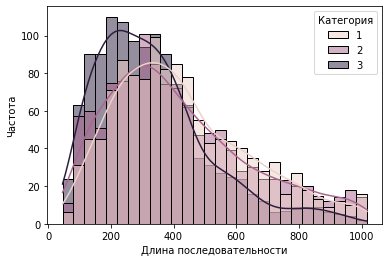

In [46]:
z = sns.histplot(overall, x='length_seq', hue='Категория',  kde=True);
z.set_xlabel('Длина последовательности')
z.set_ylabel('Частота')
plt.show()

In [67]:
p_value = stat_test('length_seq')

In [68]:
p_value

2.0011850075185256e-32

In [69]:
overall['charge_norm'] = overall['charge']/overall['length_seq']

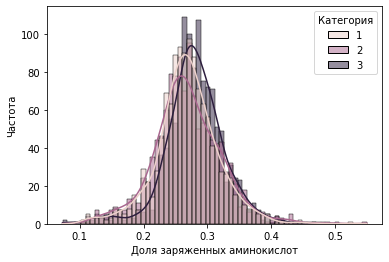

In [70]:
z = sns.histplot(overall, x='charge_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля заряженных аминокислот')
z.set_ylabel('Частота')
plt.show()

In [72]:
p_value = stat_test('charge_norm')
p_value

1.2489686716964967e-08

In [73]:
overall['polar_norm'] = overall['polar']/overall['length_seq']

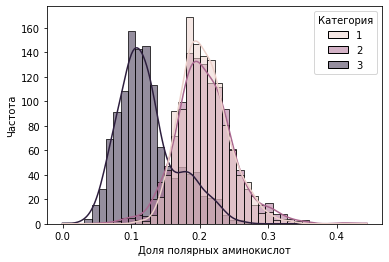

In [74]:
z = sns.histplot(overall, x='polar_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля полярных аминокислот')
z.set_ylabel('Частота')
plt.show();

In [75]:
p_value = stat_test('polar_norm')
p_value

0.0

In [76]:
overall['hydr_norm'] = overall['hydr']/overall['length_seq']

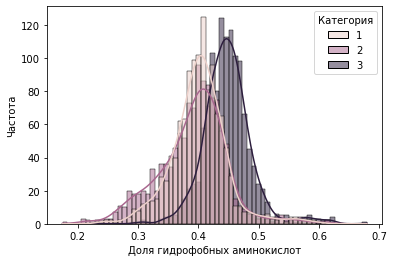

In [77]:
z = sns.histplot(overall, x='hydr_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля гидрофобных аминокислот')
z.set_ylabel('Частота')
plt.show()

In [78]:
p_value = stat_test('hydr_norm')
p_value

3.9727278942385357e-134

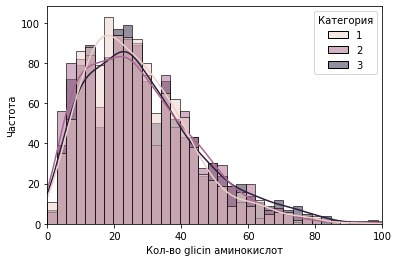

In [79]:
z = sns.histplot(overall, x='glicin', hue='Категория',  kde=True)
z.set_xlabel('Кол-во glicin аминокислот')
z.set_ylabel('Частота')
z.set_xlim(0, 100)
plt.show()

In [80]:
p_value = stat_test('glicin')
p_value

0.017777810903037438

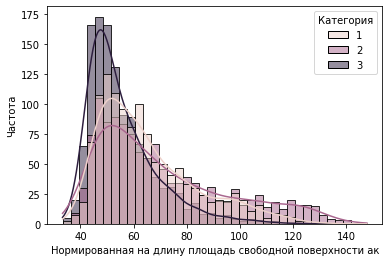

In [81]:
overall['sar_normalized'] = overall.sar/overall.length_seq # normalized sar
z = sns.histplot(data=overall, x='sar_normalized', hue='Категория',  kde=True)
z.set_xlabel('Нормированная на длину площадь свободной поверхности ак')
z.set_ylabel('Частота')
plt.show()

In [82]:
p_value = stat_test('sar_normalized')
p_value

1.0396432606700119e-47